<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Musings" data-toc-modified-id="Musings-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Musings</a></span></li></ul></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Create-dls" data-toc-modified-id="Create-dls-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create dls</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train</a></span><ul class="toc-item"><li><span><a href="#Trained-Models" data-toc-modified-id="Trained-Models-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Trained Models</a></span></li><li><span><a href="#Results-for-focal-loss" data-toc-modified-id="Results-for-focal-loss-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Results for focal loss</a></span></li></ul></li></ul></div>

# Summary

Refining previous notebook and experimenting with training. The goal of this nb is to produce an accurate model.

**Journal**
- 2020-11-17 (Tues): copied 20201027_coco_C2018_L9 notebook, renamed, and cleaned to make this nb.

**To do**
- Implement COCO metric

**Training experiments**
- resnet50
- xresnext34 (requires nout param)
- xse_resnext34 (requires nout param)

## Musings

**The anchor box approach**

The idea is to subdivide the image into chunks so we can essentially do many single bbox learners instead of one big multibox. To do this, each image must be subdivided into a grid (or multiple grids), and the labels must be remapped to individual grid cells.

Subdivide the image into cells with a grid. For each cell, generate any number of boxes from it so long as those boxes do not have a higher IOU between them and any other grid cell – the generated boxes must be able to be traced back to their grid cell via IOU. For each box generated, have it perform a 'single labeled bbox' task. Each box generated will produce one result. Keep only the most confident results & prune out any that overlap excessively.

# Data

## Create dls

In [ ]:
from fastai.vision.all import *

# params
im_sz   = 224
bs      = 128
val_pct = .10
sub_pct = .50

# paths
path = Path('/home/rory/data/coco2017')
train_im_dir, valid_im_dir = 'train2017', 'val2017'
train_json = 'annotations/instances_train2017.json'
valid_json = 'annotations/instances_val2017.json'


### Get Items ###
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_paths, train_annos = get_annos(path, train_json, train_im_dir)
valid_paths, valid_annos = get_annos(path, valid_json, valid_im_dir)
paths = train_paths + valid_paths
annos = train_annos + valid_annos
p2a = {p:b for p,b in zip(paths,annos)}
def get_bbox(p): return p2a[p][0]
def get_lbl(p):  return p2a[p][1]


### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(val_pct),
    item_tfms=Resize(im_sz, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    n_inp=1)
subset = paths.shuffle()[0:int(len(paths)*sub_pct)]
dls = db.dataloaders(subset, bs=bs)


### Inspection (IMPORTANT) ###
print("Size of train data:",len(dls.train.items))
print("Size of valid data:",len(dls.valid.items))
for i,t in enumerate(dls.one_batch()):
    print(f"batch[{i}]:",'\t',t.dtype,'\t',t.shape)

Size of train data: 54999
Size of valid data: 6110
batch[0]: 	 torch.float32 	 torch.Size([128, 3, 224, 224])
batch[1]: 	 torch.float32 	 torch.Size([128, 44, 4])
batch[2]: 	 torch.int64 	 torch.Size([128, 44])


# Model

In [ ]:
### Architecture ###
def perm(x,k):
    return x.permute(0,3,2,1).contiguous().view(x.size(0),x.size(2)*x.size(3)*k,x.size(1)//k)
class StdConv(Module):
    """(42:00) Wraps together the standard conv2d → batchnorm → dropout."""
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)

    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
class OutConv(Module):
    """Takes nin inputs, outputs two layers: one for bbs, one for lbls."""
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.bb_acts  = nn.Conv2d(nin, 4*k, 3, padding=1)             
        self.lbl_acts = nn.Conv2d(nin, len(dls.vocab)*k, 3, padding=1)
        self.lbl_acts.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        return [perm(self.bb_acts(x), self.k),
                perm(self.lbl_acts(x),self.k)]         
class SSDHead(Module):
    """Wraps StdConv and OutConv into a head module."""
    def __init__(self, k, bias, drop):
        super().__init__()
        self.drop  = nn.Dropout(drop)
        self.conv0 = StdConv(512,256, drop=drop) # most grid cells (4x4 for sz=224)
        self.out0  = OutConv(k,  256, bias)
        self.conv1 = StdConv(256,256, drop=drop)
        self.out1  = OutConv(k,  256, bias)
        self.conv2 = StdConv(256,256, drop=drop) # fewest grid cells (1x1 for sz=224)
        self.out2  = OutConv(k,  256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.conv0(x)
        bb0,lbl0 = self.out0(x)
        x = self.conv1(x)
        bb1,lbl1 = self.out1(x)
        x = self.conv2(x)
        bb2,lbl2 = self.out2(x)
        return [torch.cat([ bb0, bb1, bb2], dim=1),
                torch.cat([lbl0,lbl1,lbl2], dim=1)]
class CustomModule(Module):
    """Simple class for joining a body and a head."""
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))


### Create Anchors ###
def create_anchors(subdivs, zooms, ratios, device='cuda'):
    # create list of permutations per default anchor box
    perms = [(z*r1,z*r2) for z in zooms for (r1,r2) in ratios]
    k = len(perms)
    offsets = [1/(sd*2) for sd in subdivs]
    xs = np.concatenate([np.repeat(np.linspace(o, 1-o, sd), sd) for o,sd in zip(offsets, subdivs)])
    ys = np.concatenate([np.tile  (np.linspace(o, 1-o, sd), sd) for o,sd in zip(offsets, subdivs)])
    ctrs = np.repeat(np.stack([xs,ys], axis=1), k, axis=0)
    hws = np.concatenate([np.array([[o/sd,p/sd] for i in range(sd*sd) for o,p in perms]) for sd in subdivs])
    box_sizes = tensor(np.concatenate([np.array([1/sd for i in range(sd*sd) for o,p in perms])
                                      for sd in subdivs]), requires_grad=False).unsqueeze(1)
    anchors = tensor(np.concatenate([ctrs, hws], axis=1), requires_grad=False).float()
    return anchors.to(device), box_sizes.to(device)
def create_anchor_boxes(ctr, hw):
    return 2*torch.cat((tensor(ctr-hw/2), tensor(ctr+hw/2)), axis=1)-1


### mae, BCE_Loss, and FocalLoss ###
def mae(t1, t2):
    return ((t1 - t2).abs()).mean()
def one_hot_embedding(lbls, n_cls):
    return torch.eye(n_cls)[lbls.data.long()].cuda()
class BCELoss(nn.Module):
    # 1:05:35
    def __init__(self, n_cls):
        super().__init__()
        self.n_cls = n_cls
        
    def forward(self, act_lbl, targ_lbl):
        a = act_lbl[:,1:]
        t = one_hot_embedding(targ_lbl, self.n_cls)
        t = tensor(t[:,1:].contiguous())
        w = self.get_weight(a,t)
        return F.binary_cross_entropy_with_logits(a,t,None,reduction='sum')/self.n_cls
    
    def get_weight(self,a,t): return None 
class FocalLoss(BCELoss):
    def get_weight(self, a, t):
        alpha, gamma = 0.25, 2.0 # vals from paper
        p = a.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)
    

### IOU ###
def intersxn(b1,b2):
    x1 = torch.max((b1)[:,None,0], (b2)[None,:,0])
    y1 = torch.max((b1)[:,None,1], (b2)[None,:,1])
    x2 = torch.min((b1)[:,None,2], (b2)[None,:,2])
    y2 = torch.min((b1)[:,None,3], (b2)[None,:,3])
    return torch.clamp((x2-x1), min=0) * torch.clamp((y2-y1), min=0)
def area(b):
    return (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])
def get_iou(b1, b2):
    inter = intersxn(b1,b2)
    union = area(b1).unsqueeze(1) + area(b2).unsqueeze(0) - inter
    return inter / union


### ssd_loss ###
def remove_padding(bb, lbl):
    # 1:11:10
    bb = bb.view(-1,4)
    padding = (bb[:,2]-bb[:,0])==0
    return bb[~padding],lbl[~padding]
def adjust_anchor_boxes(act_bb, anchors, box_size):
    acts = torch.tanh(act_bb) # scale acts 
    ctrs = anchors[:,:2] + (acts[:,:2]/2 * box_size) # move ctrs by up to box_size/2
    hws  = anchors[:,2:] * (acts[:,2:]/2+1)
    return create_anchor_boxes(ctrs, hws)
def get_targ_idx(ious):
    max_iou_per_bb, anc_idxs = ious.max(1)
    max_iou_per_anc, bb_idxs = ious.max(0)
    max_iou_per_anc[anc_idxs] = 1.99
    for i,iou in enumerate(anc_idxs): bb_idxs[iou] = i
    return max_iou_per_anc, bb_idxs
def ssd_item_loss(act_bb, act_lbl, bb, lbl):
    # 1:11:30
    bb, lbl = remove_padding(bb, lbl)
    pred_bb = adjust_anchor_boxes(act_bb, anchors, box_size)
    ious = get_iou(bb.data, anchor_boxes.data)
    anc_ious, targ_idx = get_targ_idx(ious)
    targ_lbl = lbl[targ_idx]
    above_thresh = anc_ious > 0.4
    assigned_idx = torch.nonzero(above_thresh)[:,0]
    targ_lbl[~above_thresh] = 0
    targ_bb = bb[targ_idx] 
    return (bb_loss(pred_bb[assigned_idx], targ_bb[assigned_idx]),
           lbl_loss(act_lbl,               targ_lbl))
def ssd_loss(acts, bbs, lbls):
    sum_bb_loss, sum_lbl_loss = 0., 0.
    for o in zip(*acts, bbs, lbls):
        bb_loss, lbl_loss = ssd_item_loss(*o)
        sum_bb_loss  += bb_loss
        sum_lbl_loss += lbl_loss
    return sum_bb_loss + sum_lbl_loss


### show_bb & ResultShower ###
def show_bb(im, bb, lbl, sz=im_sz, figsz=5, color='white', ctx=None, title=None):
    # process tensors to take advantage of fastai show methods
    bbox = TensorBBox((bb+1)*sz//2)
    labeledbbox = LabeledBBox(bbox,lbl)
    
    if ctx:       show_image(im, figsize=[figsz,figsz], title=title, ctx=ctx)
    else:   ctx = show_image(im, figsize=[figsz,figsz], title=title)
    
    labeledbbox.show(ctx=ctx)       # first, draw white lbl bbs...
    bbox.show(ctx=ctx, color=color) # ... then overlay color bbs.
    return ctx
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2-x1, y2-y1)
    v, idx = scores.sort(0) # sort asc
    idx = idx[-top_k:] # idxs of the top-k lrgst vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()
    
    count = 0
    while idx.numel() > 0:
        i = idx[-1] # idx of current lrgst val
        keep[count] = i
        count+=1
        if idx.size(0) == 1: break
        idx = idx[:-1] # remove kept element from view
        # load bboxes
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, min=x2[i])
        yy2 = torch.clamp(yy2, min=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2... after each iter
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU
        rem_areas = torch.index_select(area, 0, idx)
        union = (rem_areas - inter) + area[i]
        iou = inter/union
        idx = idx[iou.le(overlap)]
    return keep, count
class ResultShower():
    def __init__(self, dls, lrn, ancs, anc_sz):
        self.dls,self.mod,self.ancs,self.anc_sz = dls,lrn.model,ancs,anc_sz
        self.batch    = next(iter(dls.cpu().valid))
        self.dls.cuda()
        self.acts     = self.mod.cpu()(self.batch[0])
        self.mod.cuda()
        self.acts     = [a.data for a in self.acts]
        self.im_size  = self.batch[0].shape[-1]
        self.last_res = 0
        
    def __call__(self, *args, **kwargs):
        return self.show_results(*args, **kwargs)
        
    def show_results(self, n, overlap=.5, conf=.1, figsz=8, use_nms=True):
        b_ims,b_bbs,b_lbls = self.batch
        act_bbs,act_lbls = self.acts
    
        for i in range(n):
            idx=self.last_res+i

            # grab im, targ, acts
            im = self.dls.decode(self.batch)[0][idx]
            bb  = b_bbs[idx]
            lbl = b_lbls[idx]
            act_bb  = act_bbs[idx]
            act_lbl = act_lbls[idx]

            # convert acts to preds
            pred_bb = adjust_anchor_boxes(act_bb,self.ancs,self.anc_sz)
            pred_lbl = act_lbl.max(1)[1]
            lbl_conf = act_lbl.max(1)[0].sigmoid().data

            # nms
            if use_nms:
                nms_idxs, nms_n = nms(pred_bb.data, lbl_conf, overlap)
                nms_idxs = nms_idxs[:nms_n]
                pred_bb  = pred_bb[nms_idxs]
                pred_lbl = pred_lbl[nms_idxs]
                lbl_conf = lbl_conf[nms_idxs]

            # filter out bg and low-conf w/ mask
            is_not_bg = (pred_lbl!=0)
            is_confident = lbl_conf > conf
            mask = is_not_bg & is_confident
            pred_bb = pred_bb[mask]
            pred_lbl = pred_lbl[mask]

            # show pred
            ctx = get_grid(2, figsize=[figsz,figsz])
            show_bb(im, bb, dls.vocab[lbl], sz=self.im_size, ctx=ctx[0]);
            show_bb(im, pred_bb, dls.vocab[pred_lbl], sz=self.im_size,
                    color='magenta', ctx=ctx[1]);
        self.last_res+=n

# Train

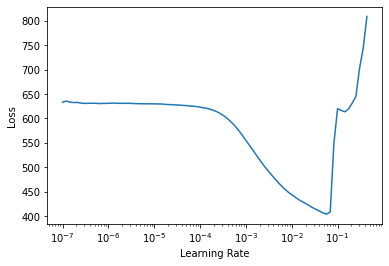

In [ ]:
# init ancs
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)
anchors, box_size = create_anchors(subdivs, zooms, ratios)
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])

# init learner
bb_loss = mae
lbl_loss = FocalLoss(len(dls.vocab))
mod = CustomModule(create_body(resnet34, pretrained=True), SSDHead(k, -4., drop=.4))
learner = Learner(dls, mod, loss_func=ssd_loss)

# train
learner.freeze()
lr_min,lr_max = learner.lr_find()

In [ ]:
(lr_min+lr_max)/2

0.0035999195300973953

In [ ]:
learner.fit_one_cycle(10, lr=(lr_min+lr_max)/2)

epoch,train_loss,valid_loss,time
0,145.882126,134.229263,03:45
1,112.898346,110.167007,03:47
2,105.078148,103.249008,03:47
3,95.472252,99.523209,03:47
4,88.331566,91.447906,03:47
5,79.517380,88.947906,03:47
6,71.162079,86.868721,03:47
7,64.759125,86.307213,03:47
8,59.809982,87.057671,03:47
9,57.299587,87.641663,03:47


In [ ]:
learner.final_record

(#2) [57.29958724975586,87.64166259765625]

In [ ]:
learner.export('models/20201117_coco_ssd_resnet34_50pct.pkl')

In [ ]:
learner.save('s1')

Path('models/s1.pth')

In [ ]:
learner.final_record[1]/bs

0.6847004890441895

## Trained Models

2020-11-16
- `'models/20201116_coco_ssd_moar_53.pkl'`
    - valid loss: 53
    - 5 epochs with one layer frozen
    - lr: 2e-3
    - first time trained with perm instead of flatten_loss
- `'models/20201116_coco_focal_47.pkl'`
    - valid loss: 47
    - 5 epochs with two layers frozen
    - lr: 3e-3
    - first time trained with perm instead of flatten_loss
    - deep trained to produce the following model (didn't improve results)

2020-11-17
- **Baseline: resnet34 w/ 10% of data**
    - valid_loss = 100
    - fit_one_cycle(10, lr=2e-3)
    - 48s per epoch
    - resnet34
    - dls.n_cls = 36
    - data params
        - im_size    = 224
        - batch_size = 128
        - valid_pct  = .10
        - subset_pct = .1
    - Exported to `models/20201117_coco_ssdfocal_0.pkl`
    - Note: my attempts to unfreeze and train further have been unsuccessful
- **xresnet34 w/ 10% of data**
    - Summary
        - Testing **xresnet34** vs the baseline
        - Result: similar or possibly worse
        - valid_loss = 113
    - Training
        - fit_one_cycle(10, lr=3e-3)
        - 52s per epoch
    - Data
        - im_size    = 224
        - batch_size = 128
        - valid_pct  = .10
        - subset_pct = .1
        - n_cls = 38
- **xresnet34 w/ 20% of data**
    - valid_loss = 111
    - fit_one_cycle(5, lr=3e-3)
    - 1:40 per epoch (wasn't it taking 2:40 earlier? is this due to batch size?)
    - data params
        - im_size    = 224
        - batch_size = 128
        - valid_pct  = .10
        - subset_pct = **.2**
- **resnet34 w/ 10% of data & bs=64**
    - I'm running this to see if I get better results than the baseline with a lower bs
        - Oh baby, I'm getting a lower loss, but I see now that *loss sums over the batch!* Lower bs will almost always have lower loss.
        - For example, the starting valid loss is 80, which is exactly half of the starting loss from the sessions with a larger bs.
        - I need a metric! I suppose I can use valid_loss/bs for now?
    - valid_loss = 53
    - fit_one_cycle(5, lr=3e-3) 
    - data params
        - im_sz   = 224
        - bs      = **64**
        - val_pct = .10
        - sub_pct = .10
- **resnet34 fine_tune**
    - Testing fine_tune vs fit_one_cycle. I expect fine_tune to outperform.
    - Result: fine_tune did not improve the result and required an additional epoch to match the above model's loss.
    - valid_loss = 54
    - **fine_tune**(3, freeze_epochs=3, lr=slice(lr/100,lr))
    - data params
        - im_sz   = 224
        - bs      = 64
        - val_pct = .10
        - sub_pct = .10
- **resnet34 w/ 50% of data**
    - Let's see how much more data helps the result.
    - Result: 88
        - best valid_loss on 7th epoch (vl = 86)
        - started overfitting on 8th epoch (vl = 87)
    - vl/bs = .685
    - fit_one_cycle(10, lr=(lr_min+lr_max)/2)
    - 227s per epoch
    - lr = 3.6e-3
    - data params
        - im_sz   = 224
        - bs      = 128
        - val_pct = .10
        - sub_pct = **.50**
    - Exported to `models/20201117_coco_ssd_resnet34_50pct.pkl`

## Results for focal loss

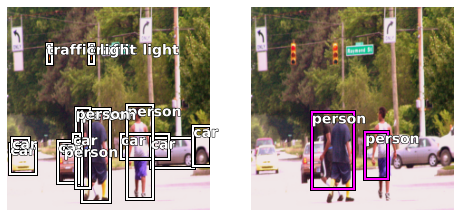

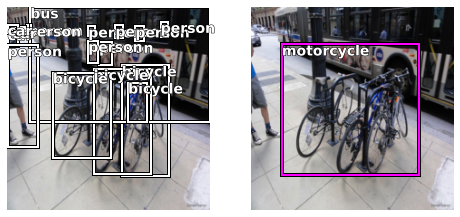

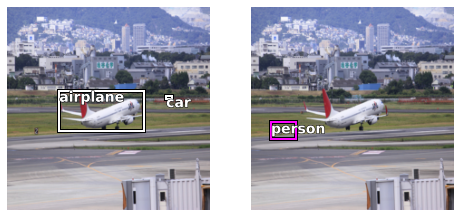

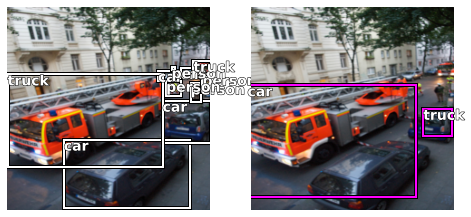

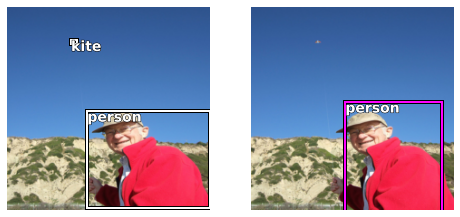

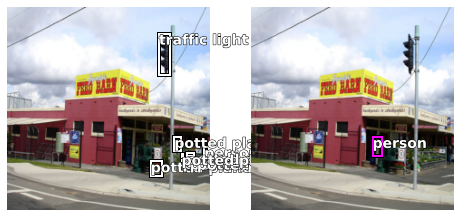

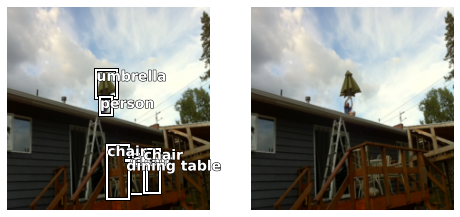

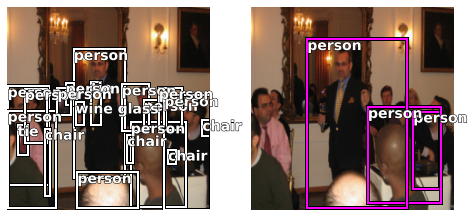

In [ ]:
baseline_learner = load_learner('models/20201117_coco_ssdfocal_0.pkl')
baseline_results = ResultShower(dls, baseline_learner, anchors.cpu(), box_size.cpu())
baseline_results(8)